# Insurance cost prediction using linear regression

## Objectives 🚀

Predict the price of yearly medical bills.

*Source* : Kaggle Challenge : [Medical Cost Personal Datasets](https://www.kaggle.com/mirichoi0218/insurance)

## Context

Insurance companies want to **determine the yearly insurance premium for a person** and they use information like a person's age, sex, BMI, no. of children and smoking habit **to predict the price of yearly medical bills**. Here, I use **Linear Regression model with `PyTorch`** to make prediction.

## Prerequisites

- I use `PyTorch` Library (**version 1.5.0**) to create model: `PyTorch` is an open source machine learning library based on the Torch library, developed by Facebook's AI Research lab. You can find documentation [here](https://pytorch.org/docs/stable/index.html).
- I use `Jovian.ml` platform for this project : `Jovian.ml` is a better place for your data science projects, Jupyter notebooks, machine learning models, experiment logs, results and more.

## Dataset

📥 I download the dataset on [Kaggle](https://www.kaggle.com/mirichoi0218/insurance).

The dataset contains personal informations :
- `age` : age of primary beneficiary
- `sex` : insurance contractor gender, female, male
- `bmi` : Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally `18.5` to `24.9`
- `children` : Number of children covered by health insurance / Number of dependents
- `smoker` : Smoking
- `region` : the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
- `charges` : Individual medical costs billed by health insurance

## Library Installation

In [1]:
!conda install numpy pytorch torchvision cpuonly -c pytorch -y
!pip install matplotlib --upgrade --quiet
!pip install jovian --upgrade --quiet
!pip install pandas --upgrade --quiet
!pip install seaborn --upgrade --quiet

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /srv/conda/envs/notebook

  added / updated specs:
    - cpuonly
    - numpy
    - pytorch
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blas-2.15                  |              mkl          10 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py37hc8dfbb8_0         151 KB  conda-forge
    cpuonly-1.0                |                0           2 KB  pytorch
    freetype-2.10.2            |       he06d7ca_0         905 KB  conda-forge
    intel-openmp-2020.1        |              217         780 KB  defaults
    jpeg-9d                    |       h5169

## Library Importation

In [1]:
import jovian

#Data Manipulation
import pandas as pd

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#PyTorch Library
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [2]:
project_name='02-insurance-linear-regression' # will be used by jovian.commit

## 1. Exploration Data Analysis

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [3]:
#Define dataset path :
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"

# Download insurance dataset
download_url(DATASET_URL, '.')

Using downloaded and verified file: ./insurance.csv


To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [4]:
#Load csv file with pandas dataframe
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data, I fill in my name below as a string.

In [5]:
your_name = 'Jennifer' # at least 5 characters

The `customize_dataset` function will customize the dataset slightly using my name as a source of random numbers.

In [6]:
def customize_dataset(dataframe_raw, rand_str):
    '''This function customizes the dataset slightly using my name as a source of random numbers.
    
    Parameters
    ------------
    dataframe_raw : pandas dataframe
        contains a dataframe to customize
    rand_str : str
        contains a string to generate a random numbers
    
    Returns
    ------------
    dataframe : pandas dataframe
        contains the new customized dataframe
    '''
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [7]:
# Use function to customize insurance dataset
dataframe = customize_dataset(dataframe_raw, your_name)

#Show the first five rows of data
dataframe.head()

,age,sex,bmi,children,smoker,region,charges
676,55,female,41.21810,3,no,southeast,13734.380990
217,27,male,23.33100,0,no,southeast,2732.109600
864,51,male,25.65400,0,no,southwest,9660.715900
751,21,male,29.26475,0,no,northwest,2096.994075
1106,49,female,30.22425,0,no,northwest,9886.974625


### 1.1 Data Cleaning and Exploration

In [8]:
#Show the first five rows of data
dataframe.head()

,age,sex,bmi,children,smoker,region,charges
676,55,female,41.21810,3,no,southeast,13734.380990
217,27,male,23.33100,0,no,southeast,2732.109600
864,51,male,25.65400,0,no,southwest,9660.715900
751,21,male,29.26475,0,no,northwest,2096.994075
1106,49,female,30.22425,0,no,northwest,9886.974625


In [9]:
dataframe.shape

(1271, 7)

As we can see, the dataset has **1270 rows** and **7 columns** as follows:
- `age` : age of primary beneficiary
- `sex` : insurance contractor gender, female, male
- `bmi` : Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally `18.5` to `24.9`
- `children` : Number of children covered by health insurance / Number of dependents
- `smoker` : Smoking
- `region` : the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
- `charges` : Individual medical costs billed by health insurance

In [10]:
num_rows = dataframe.shape[0]
print(num_rows)

1271


In [11]:
num_cols = dataframe.shape[1]
print(num_cols)

7


In [12]:
# Column titles of the input variables ?
input_cols = list(dataframe.columns.values[:-1])
input_cols

['age', 'sex', 'bmi', 'children', 'smoker', 'region']

The dataset contains **interger, float and string** values :

In [13]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1271 entries, 676 to 1115
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1271 non-null   int64  
 1   sex       1271 non-null   object 
 2   bmi       1271 non-null   float64
 3   children  1271 non-null   int64  
 4   smoker    1271 non-null   object 
 5   region    1271 non-null   object 
 6   charges   1271 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 79.4+ KB


Next, I display some **statistical summaries of the numerical and non-numerical columns** below :

In [15]:
# Statistical summaries of the numerical columns
dataframe.describe()

,age,bmi,children,charges
count,1271.000000,1271.000000,1271.000000,1271.000000
mean,39.091267,30.896019,1.113297,14584.029112
std,13.986028,6.139402,1.206833,13320.156096
min,18.000000,16.119600,0.000000,1234.061290
25%,26.000000,26.451900,0.000000,5201.902613
50%,39.000000,30.603000,1.000000,10297.459480
75%,51.000000,34.946000,2.000000,18284.318338
max,64.000000,53.661300,5.000000,70147.470811


In [16]:
# Statistical summaries of the non-numerical columns
dataframe.describe(include='object')

,sex,smoker,region
count,1271,1271,1271
unique,2,2,4
top,male,no,southeast
freq,640,1011,341


This following columns represents **categorial variables**.

In [14]:
categorical_cols = list(dataframe.describe(include='object').columns.values)
categorical_cols

['sex', 'smoker', 'region']

`charges` columns is the target : It's a **Supervised Machine Learning case (Regression).**

In [15]:
output_cols = ['charges']
output_cols

['charges']

Some relevant informations with **Data Cleaning** are :

- **No null values** :

In [16]:
# Number of null values# 
dataframe.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

- **1 duplicates** :

In [17]:
# Number of duplicates
dataframe.duplicated().sum()

1

In [18]:
#Drop duplicates
dataframe.drop_duplicates(inplace=True)

In [19]:
num_rows = dataframe.shape[0]
print(num_rows)

1270


### 1.2 Data Analysis

I analyse some statistical for insurance `charges`.

In [20]:
insurance_charges = dataframe.charges.describe()
insurance_charges

count     1270.000000
mean     14594.092506
std      13320.568924
min       1234.061290
25%       5214.315865
50%      10306.577325
75%      18303.903766
max      70147.470811
Name: charges, dtype: float64

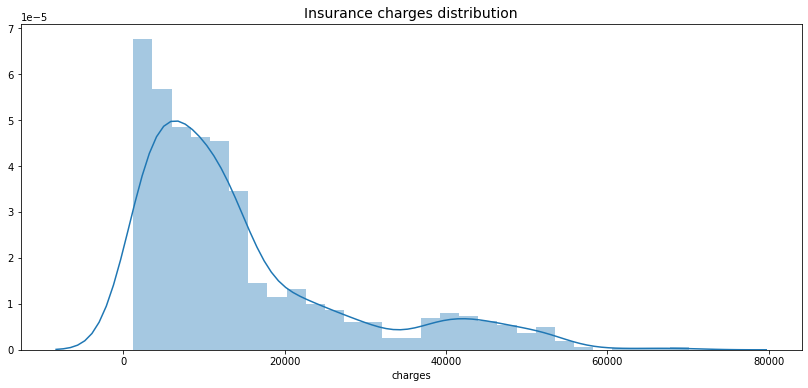

In [23]:
plt.figure(figsize=(14, 6))

plt.title("Insurance charges distribution", size=14)              #Graph Title

sns.distplot(dataframe.charges)                                   #Graph

plt.show()

Remember to commit your notebook to Jovian after every step, so that you don't lose your work.

In [24]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Updating notebook "jennifer974/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ml/jennifer974/02-insurance-linear-regression


'https://jovian.ml/jennifer974/02-insurance-linear-regression'

## 2. Data Preparation for Training

We need to convert the data from the Pandas dataframe into a `PyTorch` tensors for training. To do this, the first step is to convert it numpy arrays.

In [21]:
def dataframe_to_arrays(dataframe):
    '''This function converts Pandas dataframe into numpy arrays.
    
    Parameters
    ------------
    dataframe : pandas dataframe
        contains a dataframe to convert
    
    Returns
    ------------
    input_array : array
        contains input data
    target_array : array
        contains target data
    '''
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

In [22]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[55.    ,  0.    , 41.2181,  3.    ,  0.    ,  2.    ],
        [27.    ,  1.    , 23.331 ,  0.    ,  0.    ,  2.    ],
        [51.    ,  1.    , 25.654 ,  0.    ,  0.    ,  3.    ],
        ...,
        [53.    ,  1.    , 26.6741,  2.    ,  0.    ,  0.    ],
        [19.    ,  0.    , 40.905 ,  0.    ,  0.    ,  3.    ],
        [55.    ,  1.    , 32.9967,  1.    ,  0.    ,  2.    ]]),
 array([[13734.38099],
        [ 2732.1096 ],
        [ 9660.7159 ],
        ...,
        [12368.81459],
        [ 1935.2718 ],
        [11888.23493]]))

Now, I can convert the numpy arrays `inputs_array` and `targets_array` into `PyTorch` tensors.

In [23]:
# Convert inputs and targets to tensors
inputs = torch.from_numpy(inputs_array).float()
targets = torch.from_numpy(targets_array).float()

In [24]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

In [25]:
inputs

tensor([[55.0000,  0.0000, 41.2181,  3.0000,  0.0000,  2.0000],
        [27.0000,  1.0000, 23.3310,  0.0000,  0.0000,  2.0000],
        [51.0000,  1.0000, 25.6540,  0.0000,  0.0000,  3.0000],
        ...,
        [53.0000,  1.0000, 26.6741,  2.0000,  0.0000,  0.0000],
        [19.0000,  0.0000, 40.9050,  0.0000,  0.0000,  3.0000],
        [55.0000,  1.0000, 32.9967,  1.0000,  0.0000,  2.0000]])

In [26]:
targets

tensor([[13734.3809],
        [ 2732.1096],
        [ 9660.7158],
        ...,
        [12368.8145],
        [ 1935.2719],
        [11888.2354]])

Next, we need to create `PyTorch` datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [27]:
dataset = TensorDataset(inputs, targets)
dataset

I choose a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then I use `random_split` to create training & validation datasets.

In [28]:
val_percent = 0.15 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = random_split(dataset, [train_size, val_size]) # Use the random_split function to split dataset into 2 parts of the desired length

Finally, we can create data loaders for training & validation.

I choose a **batch size** for the data loader, it represents **the number of samples to train by epochs**.

In [52]:
batch_size = 32

In [53]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [54]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[24.0000,  0.0000, 30.5121,  3.0000,  0.0000,  1.0000],
        [40.0000,  1.0000, 35.6530,  3.0000,  0.0000,  3.0000],
        [19.0000,  0.0000, 30.8959,  2.0000,  0.0000,  1.0000],
        [24.0000,  1.0000, 40.5515,  0.0000,  1.0000,  2.0000],
        [36.0000,  1.0000, 29.9970,  0.0000,  0.0000,  2.0000],
        [54.0000,  1.0000, 24.2754,  0.0000,  0.0000,  0.0000],
        [55.0000,  0.0000, 35.5520,  0.0000,  1.0000,  2.0000],
        [58.0000,  0.0000, 28.4972,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000, 19.4930,  0.0000,  1.0000,  3.0000],
        [33.0000,  1.0000, 27.3710,  1.0000,  1.0000,  3.0000],
        [30.0000,  1.0000, 31.7140,  1.0000,  0.0000,  3.0000],
        [38.0000,  0.0000, 29.2193,  1.0000,  0.0000,  2.0000],
        [40.0000,  0.0000, 23.6037,  3.0000,  0.0000,  0.0000],
        [56.0000,  0.0000, 25.9065,  0.0000,  0.0000,  1.0000],
        [19.0000,  1.0000, 25.8106,  1.0000,  0.0000,  1.0000],
        [57.0000,  0.0000, 23.41

I save my work by committing to Jovian.

In [75]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "jennifer974/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ml/jennifer974/02-insurance-linear-regression


'https://jovian.ml/jennifer974/02-insurance-linear-regression'

## 3. Model : Linear Regression 

I use a fairly straightforward linear regression to predict insurance charges.


In [56]:
input_size = len(input_cols)
output_size = len(output_cols)

I define a class to build my model with several method (`__init__`), `forward`, `training_step` and `validation_step` methods. 

I try with **several loss to have a good loss fuction and I see which that `l1_loss` works best**. [loss documentation](https://pytorch.org/docs/stable/nn.functional.html#loss-functions) :
- `mse_loss` : Measures the element-wise mean squared error. [documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.MSELoss)
- `l1_loss` : Function that takes the mean element-wise absolute value difference. [documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.L1Loss)

In [68]:
class InsuranceModel(nn.Module):
    '''This class builds Linear Regression model.
    '''
    def __init__(self):
        '''This functions initializes class attributes.
        '''
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)        
        
    def forward(self, xb):
        out = self.linear(xb)                                   
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calculate loss
        #loss = F.mse_loss(out, targets)
        loss = F.l1_loss(out, targets)                         
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        #loss = F.mse_loss(out, targets)
        loss = F.l1_loss(out, targets)
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()           # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

I create a model using the `InsuranceModel` class. 

You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [69]:
# Initialize Insurance Model class
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [70]:
# Check out the weights and biases of the model
list(model.parameters())

[Parameter containing:
 tensor([[ 0.2808, -0.1406,  0.2760, -0.0470, -0.3090,  0.2909]],
        requires_grad=True),
 Parameter containing:
 tensor([0.3680], requires_grad=True)]

One final commit before we train the model.

In [88]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "jennifer974/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ml/jennifer974/02-insurance-linear-regression


'https://jovian.ml/jennifer974/02-insurance-linear-regression'

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [61]:
def evaluate(model, val_loader):
    '''This function evaluates model.
    
    Parameters
    ------------
    model : class
        contains Machine Learning model
    
    Returns
    ------------
    model.validation_epoch_end(outputs)
        contains results of loss
    '''
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    '''This function trains model.
    
    Parameters
    ------------
    epochs : int
        contains the number of step to train the model
    lr : float
        contains the learning rate, it's a hyper-parameter that controls how much we are adjusting the weights of our model with respect the loss gradient. 
    model : class
        contains Machine Learning model
    train_loader : pyTorch
        contains train data
    val_loader : pyTorch
        contains test data
    opt_func : pyTorch
        contains optimization function
    
    Returns
    ------------
    model.validation_epoch_end(outputs)
        contains results of model
    '''
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

I use the `evaluate` function to calculate the loss on the validation set before training.

In [71]:
# Evaluate model
result = evaluate(model, val_loader) # Use the the evaluate function
print(result)

{'val_loss': 14761.9443359375}


I train the model with different learning rates :
- `1e-2`
- `1e-3`
- `1e-4`
- `1e-5`
- `1e-6`

### Train model with `lr=1e-2`

In [74]:
# Initialize Insurance Model class
model = InsuranceModel()

# Define model parameters
epochs = 1000
lr = 1e-2

# Train model
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 8069.5327
Epoch [40], val_loss: 7930.2798
Epoch [60], val_loss: 7833.2388
Epoch [80], val_loss: 7750.5093
Epoch [100], val_loss: 7674.0728
Epoch [120], val_loss: 7602.4126
Epoch [140], val_loss: 7535.4551
Epoch [160], val_loss: 7484.9668
Epoch [180], val_loss: 7446.4839
Epoch [200], val_loss: 7417.4761
Epoch [220], val_loss: 7395.9800
Epoch [240], val_loss: 7380.9956
Epoch [260], val_loss: 7368.7065
Epoch [280], val_loss: 7359.6890
Epoch [300], val_loss: 7352.6743
Epoch [320], val_loss: 7348.7554
Epoch [340], val_loss: 7346.1816
Epoch [360], val_loss: 7345.0728
Epoch [380], val_loss: 7342.2656
Epoch [400], val_loss: 7340.3501
Epoch [420], val_loss: 7338.3691
Epoch [440], val_loss: 7337.3931
Epoch [460], val_loss: 7334.3066
Epoch [480], val_loss: 7333.0684
Epoch [500], val_loss: 7333.6831
Epoch [520], val_loss: 7330.0312
Epoch [540], val_loss: 7328.9805
Epoch [560], val_loss: 7326.7227
Epoch [580], val_loss: 7326.6909
Epoch [600], val_loss: 7326.0605
Epoch [620], v

In [78]:
# Check out the weights and biases of the model
list(model.parameters())

[Parameter containing:
 tensor([[277.5936, -20.0991, -86.7901,  84.4548,  70.5775, -50.0102]],
        requires_grad=True),
 Parameter containing:
 tensor([-17.3027], requires_grad=True)]

In [79]:
# Evaluate model
result1 = evaluate(model, val_loader) # Use the the evaluate function
print(result1)

{'val_loss': 7305.93212890625}


### Train model with `lr=1e-3`

In [80]:
# Initialize Insurance Model class
model = InsuranceModel()

# Define model parameters
epochs = 1000
lr = 1e-3

# Train model
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 13025.5195
Epoch [40], val_loss: 11443.7031
Epoch [60], val_loss: 10240.2041
Epoch [80], val_loss: 9370.5908
Epoch [100], val_loss: 8809.1123
Epoch [120], val_loss: 8478.1328
Epoch [140], val_loss: 8288.0518
Epoch [160], val_loss: 8180.1724
Epoch [180], val_loss: 8111.5347
Epoch [200], val_loss: 8069.8110
Epoch [220], val_loss: 8043.8228
Epoch [240], val_loss: 8023.1587
Epoch [260], val_loss: 8007.2954
Epoch [280], val_loss: 7994.7461
Epoch [300], val_loss: 7983.0308
Epoch [320], val_loss: 7972.0781
Epoch [340], val_loss: 7961.4722
Epoch [360], val_loss: 7950.9790
Epoch [380], val_loss: 7940.7026
Epoch [400], val_loss: 7930.6587
Epoch [420], val_loss: 7920.5464
Epoch [440], val_loss: 7910.3735
Epoch [460], val_loss: 7900.4800
Epoch [480], val_loss: 7890.5957
Epoch [500], val_loss: 7880.9419
Epoch [520], val_loss: 7871.3364
Epoch [540], val_loss: 7861.9341
Epoch [560], val_loss: 7852.5288
Epoch [580], val_loss: 7843.1187
Epoch [600], val_loss: 7833.8003
Epoch [620]

In [81]:
# Evaluate model
result2 = evaluate(model, val_loader) # Use the the evaluate function
print(result2)

{'val_loss': 7674.89111328125}


### Train model with `lr=1e-4`

In [82]:
# Initialize Insurance Model class
model = InsuranceModel()

# Define model parameters
epochs = 1000
lr = 1e-4

# Train model
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 14620.8369
Epoch [40], val_loss: 14447.6943
Epoch [60], val_loss: 14274.5635
Epoch [80], val_loss: 14101.4385
Epoch [100], val_loss: 13928.2979
Epoch [120], val_loss: 13755.1572
Epoch [140], val_loss: 13582.0029
Epoch [160], val_loss: 13408.8525
Epoch [180], val_loss: 13235.9893
Epoch [200], val_loss: 13064.5459
Epoch [220], val_loss: 12894.6758
Epoch [240], val_loss: 12726.3701
Epoch [260], val_loss: 12558.8779
Epoch [280], val_loss: 12392.9375
Epoch [300], val_loss: 12230.8750
Epoch [320], val_loss: 12071.9033
Epoch [340], val_loss: 11916.1162
Epoch [360], val_loss: 11765.6025
Epoch [380], val_loss: 11619.0273
Epoch [400], val_loss: 11475.4131
Epoch [420], val_loss: 11337.8154
Epoch [440], val_loss: 11204.6162
Epoch [460], val_loss: 11073.5967
Epoch [480], val_loss: 10944.3467
Epoch [500], val_loss: 10818.9678
Epoch [520], val_loss: 10699.9902
Epoch [540], val_loss: 10587.6289
Epoch [560], val_loss: 10477.8350
Epoch [580], val_loss: 10369.9238
Epoch [600], val_l

In [83]:
# Evaluate model
result3 = evaluate(model, val_loader) # Use the the evaluate function
print(result3)

{'val_loss': 8819.326171875}


### Train model with `lr=1e-5`

In [84]:
# Initialize Insurance Model class
model = InsuranceModel()

# Define model parameters
epochs = 1000
lr = 1e-5
# Train model
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 14777.1133
Epoch [40], val_loss: 14759.7969
Epoch [60], val_loss: 14742.4814
Epoch [80], val_loss: 14725.1670
Epoch [100], val_loss: 14707.8516
Epoch [120], val_loss: 14690.5361
Epoch [140], val_loss: 14673.2217
Epoch [160], val_loss: 14655.9062
Epoch [180], val_loss: 14638.5908
Epoch [200], val_loss: 14621.2764
Epoch [220], val_loss: 14603.9580
Epoch [240], val_loss: 14586.6406
Epoch [260], val_loss: 14569.3252
Epoch [280], val_loss: 14552.0107
Epoch [300], val_loss: 14534.6963
Epoch [320], val_loss: 14517.3799
Epoch [340], val_loss: 14500.0674
Epoch [360], val_loss: 14482.7510
Epoch [380], val_loss: 14465.4375
Epoch [400], val_loss: 14448.1250
Epoch [420], val_loss: 14430.8057
Epoch [440], val_loss: 14413.4912
Epoch [460], val_loss: 14396.1748
Epoch [480], val_loss: 14378.8594
Epoch [500], val_loss: 14361.5469
Epoch [520], val_loss: 14344.2305
Epoch [540], val_loss: 14326.9170
Epoch [560], val_loss: 14309.6016
Epoch [580], val_loss: 14292.2881
Epoch [600], val_l

In [85]:
# Evaluate model
result4 = evaluate(model, val_loader) # Use the the evaluate function
print(result4)

{'val_loss': 13928.6650390625}


### Train model with `lr=1e-6`

In [86]:
# Initialize Insurance Model class
model = InsuranceModel()

# Define model parameters
epochs = 1000
lr = 1e-6

# Train model
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 14758.9443
Epoch [40], val_loss: 14757.2119
Epoch [60], val_loss: 14755.4805
Epoch [80], val_loss: 14753.7490
Epoch [100], val_loss: 14752.0166
Epoch [120], val_loss: 14750.2852
Epoch [140], val_loss: 14748.5547
Epoch [160], val_loss: 14746.8232
Epoch [180], val_loss: 14745.0908
Epoch [200], val_loss: 14743.3604
Epoch [220], val_loss: 14741.6260
Epoch [240], val_loss: 14739.8975
Epoch [260], val_loss: 14738.1641
Epoch [280], val_loss: 14736.4336
Epoch [300], val_loss: 14734.7021
Epoch [320], val_loss: 14732.9697
Epoch [340], val_loss: 14731.2383
Epoch [360], val_loss: 14729.5078
Epoch [380], val_loss: 14727.7764
Epoch [400], val_loss: 14726.0430
Epoch [420], val_loss: 14724.3125
Epoch [440], val_loss: 14722.5811
Epoch [460], val_loss: 14720.8506
Epoch [480], val_loss: 14719.1182
Epoch [500], val_loss: 14717.3867
Epoch [520], val_loss: 14715.6553
Epoch [540], val_loss: 14713.9219
Epoch [560], val_loss: 14712.1914
Epoch [580], val_loss: 14710.4609
Epoch [600], val_l

In [87]:
# Evaluate model
result5 = evaluate(model, val_loader) # Use the the evaluate function
print(result5)

{'val_loss': 14674.09765625}


**Q: What is the final validation loss of your model?**

The best `l1_loss` is for model with following parameters :
- `batch_size` = 32
- `epochs` = 1000
- `lr` = 1e-2

In [97]:
val_loss = list(result1.values())[0]
val_loss

7305.93212890625

Let's log the final validation loss to Jovian and commit the notebook

In [98]:
jovian.log_metrics(val_loss=val_loss)

[jovian] Metrics logged.


In [99]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "jennifer974/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/jennifer974/02-insurance-linear-regression


'https://jovian.ml/jennifer974/02-insurance-linear-regression'

## Step 5: Make predictions using the trained model

I define functions to make predictions on a single input :

In [100]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(input)               
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [101]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([33.0000,  0.0000, 39.2890,  3.0000,  0.0000,  3.0000])
Target: tensor([6569.6157])
Prediction: tensor(105.2987)


In [102]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([64.0000,  0.0000, 27.1539,  0.0000,  1.0000,  1.0000])
Target: tensor([32264.0820])
Prediction: tensor(143.6450)


In [103]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([27.0000,  1.0000, 30.6030,  3.0000,  0.0000,  3.0000])
Target: tensor([4686.8184])
Prediction: tensor(84.5811)


**Conclusion : The results is very bad, I will change hyperparameters (`epochs`, `learning_rate`...) and loss function to improve my results.**

In [ ]:
jovian.commit(project=project_name, environment=None)
jovian.commit(project=project_name, environment=None) # try again, kaggle fails sometimes

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "jennifer974/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/jennifer974/02-insurance-linear-regression


<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..


## Save my work

In [ ]:
import jovian
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
